### Import The Libraries

In [2]:
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from glob import glob
from os import listdir
import pandas as pd
import datetime as dt
from sklearn.metrics.pairwise import rbf_kernel
from mpl_toolkits.mplot3d import Axes3D
import GPy
import time
import numpy as np
from sklearn.model_selection import KFold
from  sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Prepare The Data

In [3]:
"""
Load the data from the files and split them into test and train data.
"""

years = range(2011, 2016)
path = "/Users/asmaaaly/yosemite_village/"
files = listdir(path)
updated_files = []
for f in files:
    traget_files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
    for _ in traget_files:
        updated_files.append(path+ _)
usecols = [1, 2, 8]

train_data = [np.loadtxt(_, usecols=usecols) for _ in updated_files]
test_data = [np.loadtxt(path+'CRNS0101-05-2016-CA_Yosemite_Village_12_W.txt',usecols=usecols)]
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)
# Map from HHmm to an integer
train_data[:, 1] = np.floor_divide(train_data[:, 1], 100) * 60 + np.mod(train_data[:, 1], 100)
test_data[:, 1] = np.floor_divide(test_data[:, 1], 100) * 60 + np.mod(test_data[:, 1], 100)
train_valid = train_data[:, 2] > -1000
test_valid = test_data[:, 2] > -1000

traindata = train_data[train_valid,]
test_data = test_data[test_valid,]

In [4]:
fulldata_df = pd.DataFrame(traindata)
fulldata_df.columns = ['Date', 'HHmm', 'Temperature']
fulldata_df.head()

,Date,HHmm,Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


In [5]:
test_data_df = pd.DataFrame(test_data)
test_data_df.columns = ['Date', 'HHmm', 'Temperature']
fulldata_df.head()

,Date,HHmm,Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


###  Convert the dataset into a richer format whereby the day of the year is also captured. 

In [6]:
"""
Pre-process the Data column to see the day of the year
"""
fulldata_df['Date'] = pd.to_datetime(fulldata_df['Date'], format = ('%Y%m%d'))
fulldata_df['Date'] = fulldata_df['Date'].dt.strftime('%j').astype(int)
test_data_df['Date'] = pd.to_datetime(test_data_df['Date'], format = ('%Y%m%d'))
test_data_df['Date'] = test_data_df['Date'].dt.strftime('%j').astype(int)


In [7]:
fulldata_df.head()


,Date,HHmm,Temperature
0,1,5.0,-6.4
1,1,10.0,-6.5
2,1,15.0,-6.5
3,1,20.0,-6.5
4,1,25.0,-6.7


In [8]:
test_data_df.head()

,Date,HHmm,Temperature
0,1,5.0,-1.9
1,1,10.0,-2.0
2,1,15.0,-2.1
3,1,20.0,-2.2
4,1,25.0,-2.4


### Using a sparse Gaussian process, estimate the temperature over time of day (0:00-23:59) and time of year (1-365). 


### Using the Seasonal Component 

{'inducing': <matplotlib.collections.PathCollection at 0x1a21e152e8>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x1a21e15710>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a21e155c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a21e15c88>]}

<Figure size 720x720 with 0 Axes>

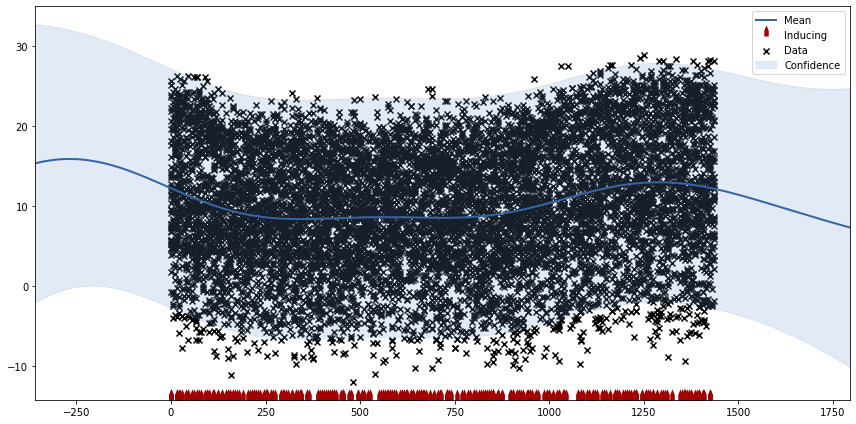

In [9]:
sample = fulldata_df.sample(n=10000)
plt.figure(figsize=(10, 10))

k = GPy.kern.RBF(1)

time_of_days = np.asarray(sample["HHmm"]).reshape(-1,1)
y = np.asarray(sample['Temperature']).reshape(-1,1)

m = GPy.models.SparseGPRegression(time_of_days,y,k,num_inducing=300)
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot(figsize=(12, 6))


## Using the Daily Component 


{'inducing': <matplotlib.collections.PathCollection at 0x1a303e8a20>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x1a303e8f28>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a303e89e8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a303f8208>]}

<Figure size 720x720 with 0 Axes>

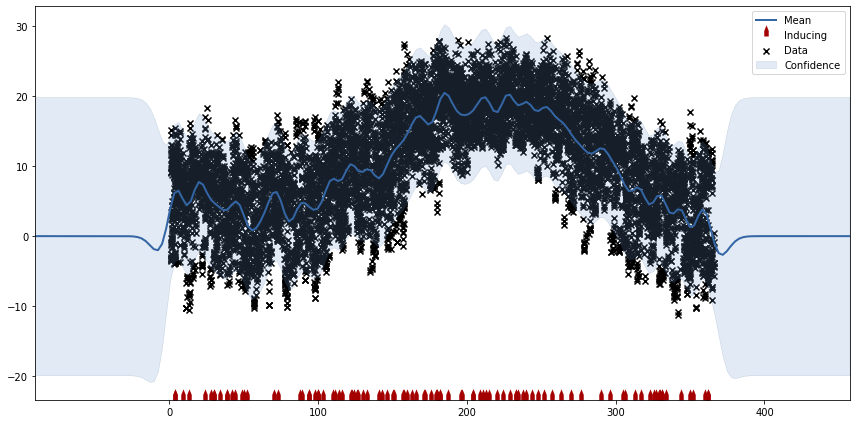

In [54]:
sample = fulldata_df.sample(n=10000)
plt.figure(figsize=(10, 10))

k = GPy.kern.RBF(1)

time_of_year = np.asarray(sample["Date"]).reshape(-1,1)
y = np.asarray(sample['Temperature']).reshape(-1,1)

m = GPy.models.SparseGPRegression(time_of_year,y,k,num_inducing=100)
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot(figsize=(12, 6))


{'inducing': <matplotlib.collections.PathCollection at 0x1a21c79e48>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x1a21ec0080>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a21ec0550>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a21ec0668>]}

<Figure size 720x720 with 0 Axes>

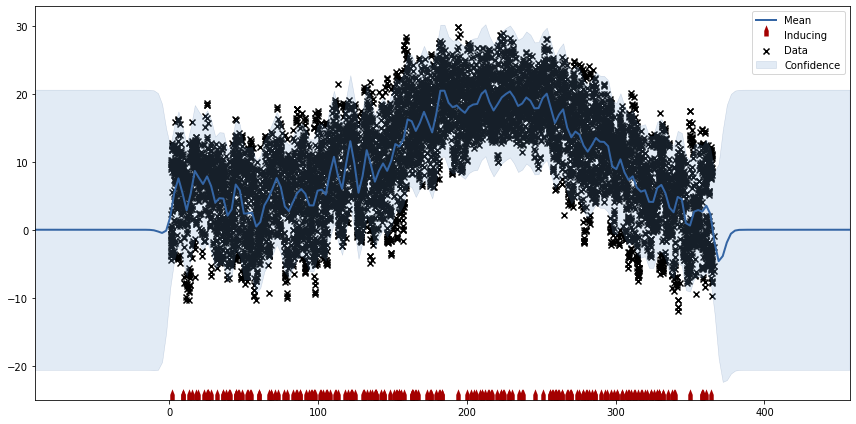

In [23]:
sample = fulldata_df.sample(n=10000)
plt.figure(figsize=(10, 10))

k = GPy.kern.RBF(1)

time_of_year = np.asarray(sample["Date"]).reshape(-1,1)
y = np.asarray(sample['Temperature']).reshape(-1,1)

m = GPy.models.SparseGPRegression(time_of_year,y,k,num_inducing=200)
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot(figsize=(12, 6))

{'inducing': <matplotlib.collections.PathCollection at 0x1a232a9dd8>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x1a232c02b0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a232c0198>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a232c0160>]}

<Figure size 720x720 with 0 Axes>

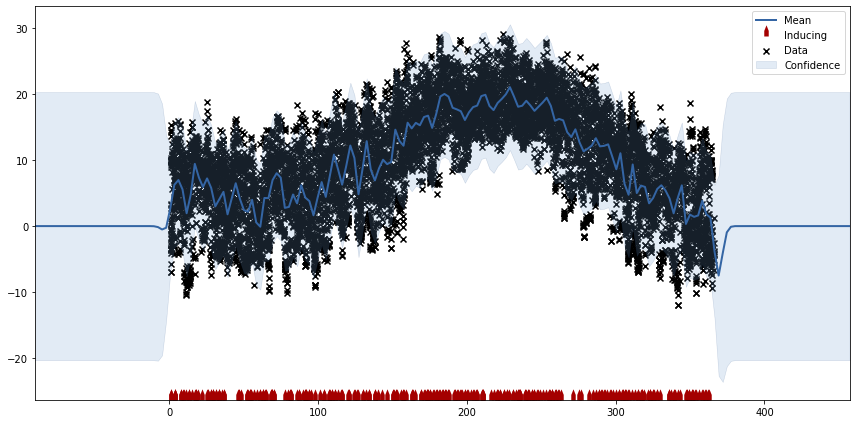

In [11]:
sample = fulldata_df.sample(n=10000)
plt.figure(figsize=(10, 10))

k = GPy.kern.RBF(1)

time_of_year = np.asarray(sample["Date"]).reshape(-1,1)
y = np.asarray(sample['Temperature']).reshape(-1,1)

m = GPy.models.SparseGPRegression(time_of_year,y,k,num_inducing=300)
m.inducing_inputs.fix()
m.optimize('bfgs')
#m.optimize('bfgs')
m.plot(figsize=(12, 6))


## Using Both Components


 //anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


40.63723199999731


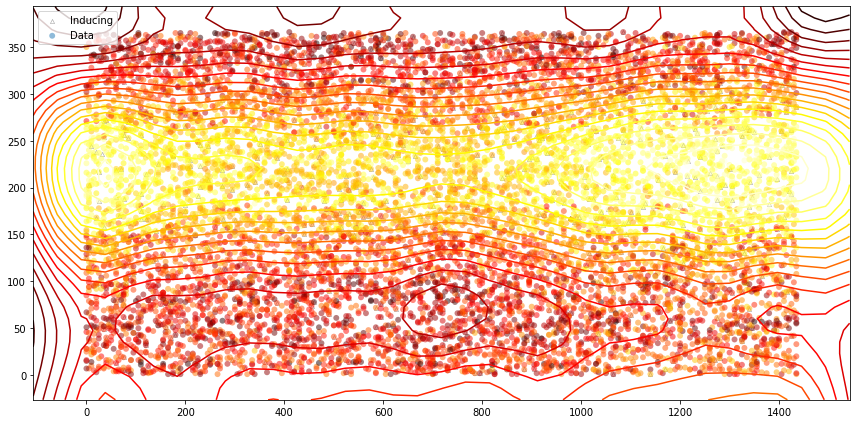

In [53]:
sample = fulldata_df.sample(n=10000)
Years = np.asarray(sample["Date"]).reshape(-1,1)
time_of_days = np.asarray(sample["HHmm"]).reshape(-1,1)
rbf = GPy.kern.RBF(2)

X = np.concatenate((time_of_days,Years), axis =1)
y = np.asarray(sample['Temperature']).reshape(-1,1)
train_start = time.process_time()

m_full_1 = GPy.models.SparseGPRegression(X,y,rbf,num_inducing=1000)
train_stop = time.process_time()
train_time = train_stop - train_start
m_full_1.optimize('bfgs')
m_full_1.plot(figsize=(12, 6))
print(train_time)

 //anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


328.95691999999985


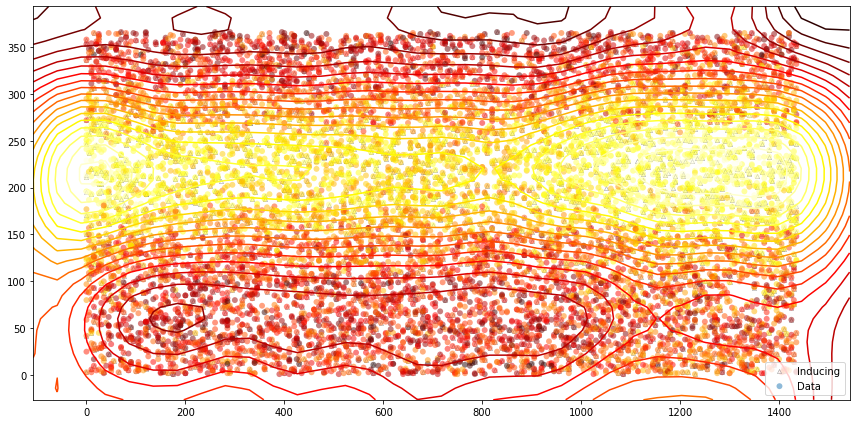

In [12]:
sample = fulldata_df.sample(n=10000)
Years = np.asarray(sample["Date"]).reshape(-1,1)
time_of_days = np.asarray(sample["HHmm"]).reshape(-1,1)
rbf = GPy.kern.RBF(2)

X = np.concatenate((time_of_days,Years), axis =1)
y = np.asarray(sample['Temperature']).reshape(-1,1)
#Z = np.hstack((np.linspace(0,1435,10),np.linspace(0,365,10)))[:,None]
train_start = time.process_time()

m_full = GPy.models.SparseGPRegression(X,y,rbf,num_inducing=4000)
train_stop = time.process_time()
train_time = train_stop - train_start
m_full.optimize('bfgs')
m_full.plot(figsize=(12, 6))
print(train_time)

## 1. Describe in detail the covariance function you chose, and why. 

I chose to work with the radial basis function as my kernel for the following reasons. First, the implementation of the RBF kernel using the GPy library was straightforward as I experience library-import related issues when I tried to test the periodic function using GPy. 2. RBFs can be integrated, using the optimization of the length scale and the variance, to model seasonal changes and overall trends, as in the yearly component. 3. Although I didn't combine multiple kernels to avoid overfitting the data, we can multiply the RBF function with constants to resemble upward trends in addition to seasonal variations. Similar to what we did for modeling the co2 data. 

### 2. Measure the mean squared error (MSE) of your Gaussian process regression, and contrast it with the MSE of your linear parameter model from a few weeks earlier. Compare and contrast the training time of your linear parameter model with the training time of the Gaussian process model.


In [43]:
y_true = test_data_df["Temperature"]
msetest = mean_squared_error(y_true, y_all_test)

In [51]:
"""
Get 250 centers of the daily and the yearly components. 
Use the rbf kernel and tranform both components
to the radial basis function presentation.
Combine the rbfs of both components and fit the Ridge 
regression model on this combination and plot the score.
"""

centers_year = np.linspace(1, 365, 250).reshape(-1, 1)
centers_day = np.linspace(1, 1435, 250).reshape(-1, 1)
years = np.asarray(fulldata_df['Date']).reshape(-1, 1)
days = np.asarray(fulldata_df['HHmm']).reshape(-1, 1)

rbf_year = rbf_kernel(years, centers_year, 1)
rbf_day = rbf_kernel(days, centers_day, 1)

centers_year_test = np.linspace(1, 365, 250).reshape(-1, 1)
centers_day_test = np.linspace(1, 1435, 250).reshape(-1, 1)
years_test = np.asarray(test_data_df['Date']).reshape(-1, 1)
days_test = np.asarray(test_data_df['HHmm']).reshape(-1, 1)

rbf_year_test = rbf_kernel(years_test, centers_year_test, 1)
rbf_day_test = rbf_kernel(days_test, centers_day_test, 1)

x_train = np.concatenate((rbf_year,rbf_day),axis = 1)
x_test = np.concatenate((rbf_year_test,rbf_day_test),axis = 1)

temps_test = test_data_df['Temperature']
temps_train = fulldata_df['Temperature']
regr_full = Ridge(alpha=0.01, fit_intercept=False)
train_start_old = time.process_time()

regr_full.fit(x_train, temps_train)
train_stop = time.process_time()
train_time_old = train_stop - train_start

test_start_old = time.process_time()
y_predicted = regr_full.predict(x_test)
test_end_old = time.process_time()
test_time_old = test_end_old - test_start_old
y_predicted_train = regr_full.predict(x_train)
mse_test = mean_squared_error(temps_test, y_predicted)


In [50]:
print("MSE on Test Data Using Gaussian Process Regression {}".format(msetest))
print("MSE on Test Data Using linear parameter model {}".format(mse_test))
print("Training Time Using Gaussian Process Regression {}".format(train_time))
print("Training Time Using linear parameter model {}".format(train_time_old))


MSE on Test Data Using Gaussian Process Regression 22.617739102444805
MSE on Validation Using Gaussian Process Regression 152.8658849288817
MSE on Test Data Using linear parameter model 26.83159769866436
Training Time Using Gaussian Process Regression 618.7197340000021
Training Time Using linear parameter model 7166.638452000003


We can see that the Gaussian Process Regression has a lower MSE value than the linear parameter model we generated in the past weeks. This MSE value is the result of using a sample of 10000 data points to train the model in addition to 3000 inducing points. I was able to decrease the MSE to its current value by increasing the inducing points from 1000. Because of the memory constraint, I was able to only use 10000 points and 3000 inducing to minimize the MSE for training, which also did yield a lower value for the MSE on the test. We can also see that the Gaussian Process model did not take as much time to train compared to the Linear Parameter model. However, this comparison is not fair as I used the whole training dataset of 50000 points to train the linear model rather than using a sample of 10000 points as I did with the Gaussian. Thus, I would say that using a Linear parameter model was memory-efficient compared to the Gaussian Process. 

### 3. Make a 3D plot showing temperature as a function of (day, time). A contour plot is also acceptable (instead of a true 3D plot).


### 3D Plot of the Original Dataset

Text(0.5, 0, 'Temperature')

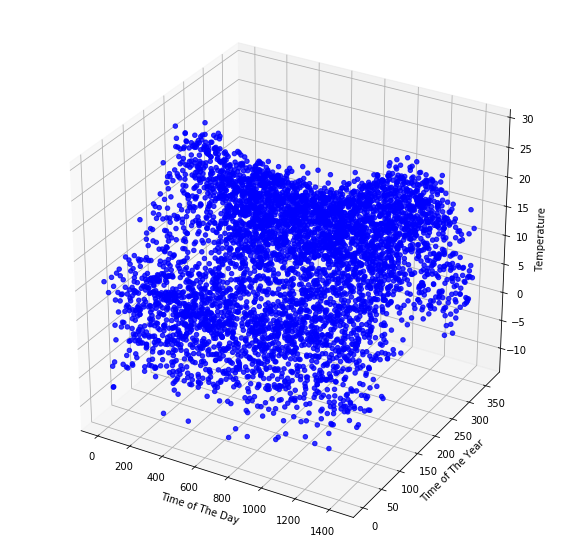

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
sample = fulldata_df.sample(n=5000)

xs = sample["HHmm"]
ys = sample["Date"]
zs = sample["Temperature"]
ax.scatter(xs, ys, zs, c='b', alpha=0.8)

ax.set_xlabel('Time of The Day')
ax.set_ylabel('Time of The Year')
ax.set_zlabel('Temperature')

### 3D Plot of the Prediction Using the Gaussian Process 

Text(0.5, 0, 'Temperature')

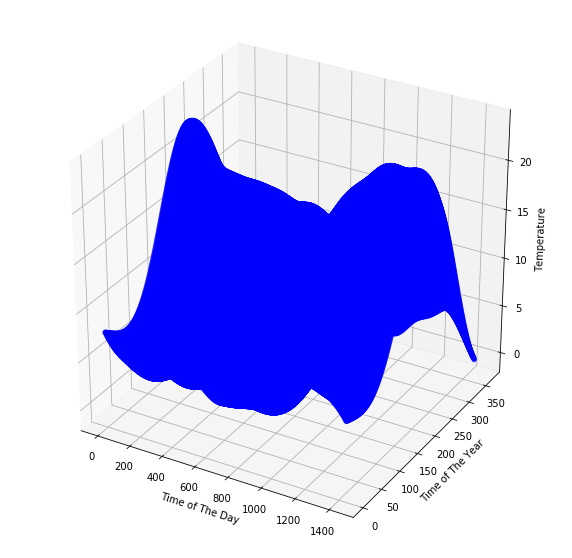

In [18]:
x__day_predict = np.asarray(test_data_df["HHmm"]).reshape(-1,1)
x__year_predict = np.asarray(test_data_df["Date"]).reshape(-1,1)
x_all_test = np.concatenate((x__day_predict,x__year_predict), axis =1)
y_all_test = np.asarray(m_full.predict(x_all_test))[0]
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
xs = x__day_predict
ys = x__year_predict
zs = y_all_test
ax.scatter(xs, ys, zs, c='b', alpha=0.5)

ax.set_xlabel('Time of The Day')
ax.set_ylabel('Time of The Year')
ax.set_zlabel('Temperature')